In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os, cv2, json, random
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using: {device}')

Using: cuda


In [2]:
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# Data Preparation

In [ ]:
splits = ['train', 'test', 'valid']

for split in splits:
    root_dir = os.path.join('brainTumorData', split)
    img_dir = os.path.join(root_dir, 'img')
    mask_dir = os.path.join(root_dir, 'mask')
    
    with open(os.path.join(root_dir, '_annotations.coco.json'), 'r') as f:
        coco = json.load(f)
    
    img_id_to_file = {img['id']: img['file_name'] for img in coco['images']}
    
    for ann in coco['annotations']:
        mask_path = os.path.join(mask_dir, img_id_to_file[ann['image_id']])
        if os.path.exists(mask_path): continue
        image_path = os.path.join(img_dir, img_id_to_file[ann['image_id']])
        img = cv2.imread(image_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        pts = np.array(ann["segmentation"][0]).reshape(-1,2).astype(np.int32)
        if (pts[0]==pts[-1]).all(): pts = pts[:-1]       

        mask = np.zeros((h, w), np.uint8)                
        cv2.fillPoly(mask, [pts], 1)                   
        cv2.imwrite(mask_path.replace('.jpg','.png'), mask)


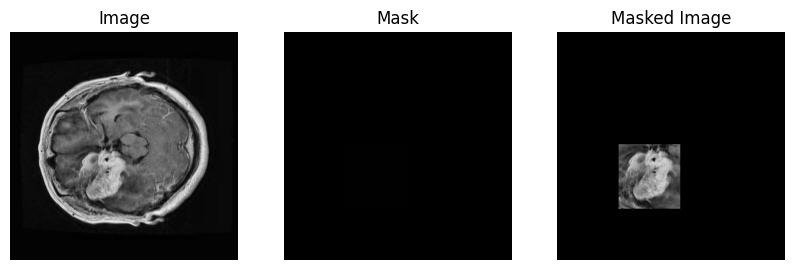

In [4]:
img_path = 'brainTumorData/train/img/2_jpg.rf.fded76c07e967829600f3509288fdfe0.jpg'
mask_path = 'brainTumorData/train/mask/2_jpg.rf.fded76c07e967829600f3509288fdfe0.png'

plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
img = cv2.imread(img_path)
plt.imshow(img)
plt.title('Image')
plt.axis('off')

plt.subplot(1, 3, 2)
mask = cv2.imread(mask_path)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
masked = img.copy()
masked[mask == 0] = 0
plt.imshow(masked)
plt.title('Masked Image')
plt.axis('off')

plt.show()

In [5]:
import albumentations as A

H, W = 224, 224

train_tf = A.Compose([
    A.RandomResizedCrop(size=(H, W), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.2),
    A.ElasticTransform(alpha=15, sigma=5, alpha_affine=5, p=0.15),
    A.RandomBrightnessContrast(0.2, 0.2, p=0.2),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    A.ToTensorV2(transpose_mask=True),
], 
    additional_targets={}, 
    is_check_shapes=True
)

val_tf = A.Compose([
    A.RandomResizedCrop(size=(H, W), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=1.0),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    A.ToTensorV2(transpose_mask=True),
])

class ImageSegmentationData(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.img_files = sorted(os.listdir(img_dir))
        self.mask_files = sorted(os.listdir(mask_dir))


    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.img_files[index])
        mask_path = os.path.join(self.mask_dir, self.mask_files[index])

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (W, H), interpolation=cv2.INTER_LINEAR)

        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST)

        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']
        
        return img.float(), mask.float()

BATCH_SIZE = 8

trn_img = 'brainTumorData/train/img'
trn_mask = 'brainTumorData/train/mask'

trn_ds = ImageSegmentationData(trn_img, trn_mask, train_tf)
trn_ldr = DataLoader(trn_ds, batch_size=BATCH_SIZE, shuffle=True)

val_img = 'brainTumorData/valid/img'
val_mask = 'brainTumorData/valid/mask'

val_ds = ImageSegmentationData(val_img, val_mask, val_tf)
val_ldr = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

test_img = 'brainTumorData/test/img'
test_mask = 'brainTumorData/test/mask'

test_ds = ImageSegmentationData(test_img, test_mask, val_tf)
test_ldr = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

C:\Users\ramom\AppData\Local\Temp\ipykernel_9012\320861682.py:9: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=15, sigma=5, alpha_affine=5, p=0.15),


In [7]:
import torch
import torch.nn as nn
from torchvision.models import resnet34

def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, bias=False),
        nn.ReLU(inplace=True),
    )

class UNetResNet34(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        try:
            from torchvision.models import ResNet34_Weights
            weights = ResNet34_Weights.IMAGENET1K_V1 if pretrained else None
            backbone = resnet34(weights=weights)
        except Exception:
            backbone = resnet34(pretrained=pretrained)

        # Encoder
        self.stem = nn.Sequential(backbone.conv1, backbone.bn1, backbone.relu)  # 64,112x112
        self.pool = backbone.maxpool                                           # ->56x56
        self.layer1 = backbone.layer1   # 64, 56x56
        self.layer2 = backbone.layer2   # 128,28x28
        self.layer3 = backbone.layer3   # 256,14x14
        self.layer4 = backbone.layer4   # 512, 7x7

        # Bottleneck
        self.conv_bottleneck = conv(512, 1024)

        # Decoder (note corrected in_channels for each concat)
        self.up_conv6 = up_conv(1024, 512)             # 7->14
        self.conv6    = conv(512 + 256, 512)           # concat with x3

        self.up_conv7 = up_conv(512, 256)              # 14->28
        self.conv7    = conv(256 + 128, 256)           # concat with x2

        self.up_conv8 = up_conv(256, 128)              # 28->56
        self.conv8    = conv(128 + 64, 128)            # concat with x1

        self.up_conv9 = up_conv(128, 64)               # 56->112
        self.conv9    = conv(64 + 64, 64)              # concat with x0

        self.up_conv10 = up_conv(64, 32)               # 112->224
        self.conv10    = conv(32, 32)                  # no skip here

        self.conv11 = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        x0 = self.stem(x)          # (64,112,112)
        x1 = self.pool(x0)         # (64,56,56)
        x1 = self.layer1(x1)       # (64,56,56)
        x2 = self.layer2(x1)       # (128,28,28)
        x3 = self.layer3(x2)       # (256,14,14)
        x4 = self.layer4(x3)       # (512, 7,7)

        # Bottleneck
        b = self.conv_bottleneck(x4)  # (1024,7,7)

        # Decoder with correct skips
        d6 = self.up_conv6(b)         # (512,14,14)
        d6 = torch.cat([d6, x3], dim=1)
        d6 = self.conv6(d6)           # (512,14,14)

        d7 = self.up_conv7(d6)        # (256,28,28)
        d7 = torch.cat([d7, x2], dim=1)
        d7 = self.conv7(d7)           # (256,28,28)

        d8 = self.up_conv8(d7)        # (128,56,56)
        d8 = torch.cat([d8, x1], dim=1)
        d8 = self.conv8(d8)           # (128,56,56)

        d9 = self.up_conv9(d8)        # (64,112,112)
        d9 = torch.cat([d9, x0], dim=1)
        d9 = self.conv9(d9)           # (64,112,112)

        d10 = self.up_conv10(d9)      # (32,224,224)
        d10 = self.conv10(d10)        # (32,224,224)

        out = self.conv11(d10)        # (out_channels,224,224)
        return out



In [8]:
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

num_classes = 2

def compute_miou(logits: torch.Tensor, targets: torch.Tensor, num_classes: int) -> float:
    preds = torch.round(torch.sigmoid(logits))

    preds = preds.view(-1)
    targets = targets.view(-1)

    iou_per_class = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = targets == cls

        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()

        if union == 0:
            continue
        iou_per_class.append(intersection / union)

    if len(iou_per_class) == 0:
        return 0.0

    return torch.mean(torch.stack(iou_per_class)).item()

def dice_loss(preds, targets, eps=1e-6):
    probs = torch.sigmoid(preds)
    inter = (probs * targets).sum(dim=(2,3))
    union = probs.sum(dim=(2,3)) + targets.sum(dim=(2,3))
    dice = 1 - (2 * inter + eps) / (union + eps)
    return dice.mean()

def bce_dice_loss(preds, targets, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(preds, targets)
    dice = dice_loss(preds, targets)
    return bce_weight * bce + (1 - bce_weight) * dice

def UNetLoss(preds, targets):
    if targets.dim() == 3:
        targets = targets.unsqueeze(1)
    loss = bce_dice_loss(preds, targets)
    probs = torch.sigmoid(preds)
    preds_bin = (probs > 0.5).float()

    acc = (preds_bin == targets).float().mean()
    miou = compute_miou(preds, targets, num_classes)

    return loss, acc, miou

def train_batch(batch, model, optimizer, criterion):
    model.train()
    imgs, masks = batch
    imgs = imgs.to(device)
    masks = masks.to(device)
    preds = model(imgs)
    loss, acc, miou = criterion(preds, masks)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item(), acc.item(), miou

@torch.no_grad()
def validate_batch(batch, model, criterion):
    model.eval()
    imgs, masks = batch
    imgs = imgs.to(device)
    masks = masks.to(device)
    preds = model(imgs)
    loss, acc, miou = criterion(preds, masks)

    return loss.item(), acc.item(), miou

In [9]:
model = UNetResNet34().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
criterion = UNetLoss
epochs = 50

from tqdm import tqdm

for epoch in range(1, epochs + 1):
    print(f"\nEpoch {epoch}/{epochs}")
    
    trn_pbar = tqdm(trn_ldr, desc=f"Training", leave=False)
    train_loss, train_acc, train_miou = 0.0, 0.0, 0.0

    for batch in trn_pbar:
        loss, acc, miou = train_batch(batch, model, optimizer, criterion)
        train_loss += loss
        train_acc += acc
        train_miou += miou
        trn_pbar.set_postfix({
            'Loss': f"{loss:.4f}",
            'Acc': f"{acc:.4f}",
            'mIoU': f"{miou:.4f}"
        })

    val_pbar = tqdm(val_ldr, desc=f"Validating", leave=False)
    val_loss, val_acc, val_miou = 0.0, 0.0, 0.0

    for batch in val_pbar:
        loss, acc, miou = validate_batch(batch, model, criterion)
        val_loss += loss
        val_acc += acc
        val_miou += miou
        val_pbar.set_postfix({
            'Loss': f"{loss:.4f}",
            'Acc': f"{acc:.4f}",
            'mIoU': f"{miou:.4f}"
        })

    steps_train = len(trn_ldr)
    steps_val = len(val_ldr)
    scheduler.step(val_loss / steps_val)
    print(f"Epoch {epoch:02d}: "
          f"Train Loss={train_loss/steps_train:.4f}, Acc={train_acc/steps_train:.4f}, mIoU={train_miou/steps_train:.4f} | "
          f"Val Loss={val_loss/steps_val:.4f}, Acc={val_acc/steps_val:.4f}, mIoU={val_miou/steps_val:.4f}")



Epoch 1/50


Epoch 01: Train Loss=0.5522, Acc=0.9306, mIoU=0.5690 | Val Loss=0.5122, Acc=0.9620, mIoU=0.6296

Epoch 2/50


Epoch 02: Train Loss=0.4711, Acc=0.9449, mIoU=0.5815 | Val Loss=0.4696, Acc=0.9615, mIoU=0.5897

Epoch 3/50


Epoch 03: Train Loss=0.4335, Acc=0.9497, mIoU=0.5997 | Val Loss=0.4921, Acc=0.9442, mIoU=0.5455

Epoch 4/50


Epoch 04: Train Loss=0.4143, Acc=0.9497, mIoU=0.6040 | Val Loss=0.9248, Acc=0.5498, mIoU=0.3049

Epoch 5/50


Epoch 05: Train Loss=0.3816, Acc=0.9490, mIoU=0.6152 | Val Loss=0.4602, Acc=0.9619, mIoU=0.5645

Epoch 6/50


Epoch 06: Train Loss=0.3569, Acc=0.9513, mIoU=0.6275 | Val Loss=0.3851, Acc=0.9570, mIoU=0.6236

Epoch 7/50


Epoch 07: Train Loss=0.3456, Acc=0.9545, mIoU=0.6378 | Val Loss=0.4555, Acc=0.9635, mIoU=0.5859

Epoch 8/50


Epoch 08: Train Loss=0.3432, Acc=0.9562, mIoU=0.6413 | Val Loss=0.3338, Acc=0.9547, mIoU=0.6574

Epoch 9/50


Epoch 09: Train Loss=0.3375, Acc=0.9566, mIoU=0.6446 | Val Loss=0.3323, Acc=0.9627, mIoU=0.6638

Epoch 10/50


Epoch 10: Train Loss=0.3318, Acc=0.9576, mIoU=0.6495 | Val Loss=0.3286, Acc=0.9566, mIoU=0.6685

Epoch 11/50


Epoch 11: Train Loss=0.3272, Acc=0.9576, mIoU=0.6521 | Val Loss=0.3091, Acc=0.9624, mIoU=0.6908

Epoch 12/50


Epoch 12: Train Loss=0.3230, Acc=0.9580, mIoU=0.6551 | Val Loss=0.3163, Acc=0.9637, mIoU=0.6741

Epoch 13/50


Epoch 13: Train Loss=0.3208, Acc=0.9588, mIoU=0.6573 | Val Loss=0.3638, Acc=0.9602, mIoU=0.6341

Epoch 14/50


Epoch 14: Train Loss=0.3196, Acc=0.9594, mIoU=0.6580 | Val Loss=0.3147, Acc=0.9671, mIoU=0.6882

Epoch 15/50


Epoch 15: Train Loss=0.3168, Acc=0.9593, mIoU=0.6593 | Val Loss=0.3957, Acc=0.9169, mIoU=0.6094

Epoch 16/50


Epoch 16: Train Loss=0.2943, Acc=0.9617, mIoU=0.6771 | Val Loss=0.2685, Acc=0.9688, mIoU=0.7261

Epoch 17/50


Epoch 17: Train Loss=0.2831, Acc=0.9645, mIoU=0.6913 | Val Loss=0.2596, Acc=0.9685, mIoU=0.7316

Epoch 18/50


Epoch 18: Train Loss=0.2821, Acc=0.9647, mIoU=0.6912 | Val Loss=0.2596, Acc=0.9666, mIoU=0.7336

Epoch 19/50


Epoch 19: Train Loss=0.2766, Acc=0.9654, mIoU=0.6969 | Val Loss=0.2546, Acc=0.9653, mIoU=0.7320

Epoch 20/50


Epoch 20: Train Loss=0.2735, Acc=0.9657, mIoU=0.6990 | Val Loss=0.2577, Acc=0.9690, mIoU=0.7337

Epoch 21/50


Epoch 21: Train Loss=0.2749, Acc=0.9650, mIoU=0.6953 | Val Loss=0.2479, Acc=0.9697, mIoU=0.7415

Epoch 22/50


Epoch 22: Train Loss=0.2691, Acc=0.9656, mIoU=0.7003 | Val Loss=0.2494, Acc=0.9708, mIoU=0.7410

Epoch 23/50


Epoch 23: Train Loss=0.2671, Acc=0.9666, mIoU=0.7045 | Val Loss=0.2503, Acc=0.9704, mIoU=0.7365

Epoch 24/50


Epoch 24: Train Loss=0.2682, Acc=0.9663, mIoU=0.7020 | Val Loss=0.2477, Acc=0.9693, mIoU=0.7411

Epoch 25/50


Epoch 25: Train Loss=0.2672, Acc=0.9656, mIoU=0.6995 | Val Loss=0.2511, Acc=0.9672, mIoU=0.7346

Epoch 26/50


Epoch 26: Train Loss=0.2654, Acc=0.9663, mIoU=0.7038 | Val Loss=0.2452, Acc=0.9683, mIoU=0.7401

Epoch 27/50


Epoch 27: Train Loss=0.2660, Acc=0.9659, mIoU=0.7029 | Val Loss=0.2414, Acc=0.9699, mIoU=0.7461

Epoch 28/50


Epoch 28: Train Loss=0.2626, Acc=0.9671, mIoU=0.7089 | Val Loss=0.2476, Acc=0.9666, mIoU=0.7351

Epoch 29/50


Epoch 29: Train Loss=0.2609, Acc=0.9668, mIoU=0.7066 | Val Loss=0.2437, Acc=0.9695, mIoU=0.7431

Epoch 30/50


Epoch 30: Train Loss=0.2614, Acc=0.9669, mIoU=0.7080 | Val Loss=0.2383, Acc=0.9696, mIoU=0.7478

Epoch 31/50


Epoch 31: Train Loss=0.2604, Acc=0.9671, mIoU=0.7092 | Val Loss=0.2382, Acc=0.9699, mIoU=0.7487

Epoch 32/50


Epoch 32: Train Loss=0.2602, Acc=0.9674, mIoU=0.7085 | Val Loss=0.2376, Acc=0.9712, mIoU=0.7515

Epoch 33/50


Epoch 33: Train Loss=0.2575, Acc=0.9677, mIoU=0.7125 | Val Loss=0.2363, Acc=0.9707, mIoU=0.7517

Epoch 34/50


Epoch 34: Train Loss=0.2557, Acc=0.9677, mIoU=0.7133 | Val Loss=0.2374, Acc=0.9705, mIoU=0.7474

Epoch 35/50


Epoch 35: Train Loss=0.2577, Acc=0.9677, mIoU=0.7123 | Val Loss=0.2376, Acc=0.9720, mIoU=0.7500

Epoch 36/50


Epoch 36: Train Loss=0.2562, Acc=0.9676, mIoU=0.7131 | Val Loss=0.2385, Acc=0.9685, mIoU=0.7443

Epoch 37/50


Epoch 37: Train Loss=0.2542, Acc=0.9677, mIoU=0.7131 | Val Loss=0.2376, Acc=0.9709, mIoU=0.7488

Epoch 38/50


Epoch 38: Train Loss=0.2480, Acc=0.9691, mIoU=0.7220 | Val Loss=0.2332, Acc=0.9704, mIoU=0.7507

Epoch 39/50


Epoch 39: Train Loss=0.2482, Acc=0.9687, mIoU=0.7224 | Val Loss=0.2325, Acc=0.9710, mIoU=0.7526

Epoch 40/50


Epoch 40: Train Loss=0.2464, Acc=0.9691, mIoU=0.7216 | Val Loss=0.2310, Acc=0.9707, mIoU=0.7531

Epoch 41/50


Epoch 41: Train Loss=0.2473, Acc=0.9691, mIoU=0.7220 | Val Loss=0.2324, Acc=0.9696, mIoU=0.7519

Epoch 42/50


Epoch 42: Train Loss=0.2469, Acc=0.9691, mIoU=0.7233 | Val Loss=0.2309, Acc=0.9703, mIoU=0.7512

Epoch 43/50


Epoch 43: Train Loss=0.2463, Acc=0.9692, mIoU=0.7231 | Val Loss=0.2281, Acc=0.9705, mIoU=0.7548

Epoch 44/50


Epoch 44: Train Loss=0.2481, Acc=0.9689, mIoU=0.7208 | Val Loss=0.2303, Acc=0.9713, mIoU=0.7547

Epoch 45/50


Epoch 45: Train Loss=0.2459, Acc=0.9692, mIoU=0.7236 | Val Loss=0.2307, Acc=0.9707, mIoU=0.7536

Epoch 46/50


Epoch 46: Train Loss=0.2483, Acc=0.9691, mIoU=0.7221 | Val Loss=0.2294, Acc=0.9715, mIoU=0.7538

Epoch 47/50


Epoch 47: Train Loss=0.2465, Acc=0.9691, mIoU=0.7231 | Val Loss=0.2287, Acc=0.9719, mIoU=0.7568

Epoch 48/50


Epoch 48: Train Loss=0.2457, Acc=0.9691, mIoU=0.7227 | Val Loss=0.2306, Acc=0.9718, mIoU=0.7539

Epoch 49/50


Epoch 49: Train Loss=0.2457, Acc=0.9692, mIoU=0.7231 | Val Loss=0.2305, Acc=0.9715, mIoU=0.7553

Epoch 50/50


Epoch 50: Train Loss=0.2443, Acc=0.9693, mIoU=0.7246 | Val Loss=0.2304, Acc=0.9696, mIoU=0.7517


In [10]:
test_loss, test_acc, test_miou = 0.0, 0.0, 0.0

for batch in tqdm(test_ldr, desc="Testing", leave=False):
    imgs, masks = batch
    loss, acc, miou = validate_batch(batch, model, criterion)
    
    test_loss += loss
    test_acc += acc
    test_miou += miou

n_batches = len(test_ldr)
test_loss /= n_batches
test_acc /= n_batches
test_miou /= n_batches

print(f"Test Loss={test_loss:.4f}, Acc={test_acc:.4f}, mIoU={test_miou:.4f}")

Test Loss=0.2419, Acc=0.9688, mIoU=0.7442


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.448279].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7411593..1.925403].


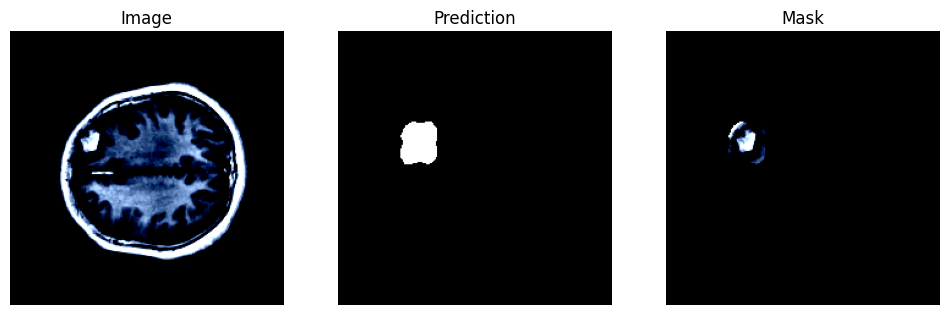

In [98]:
@torch.no_grad()
def predict(img_path):
    model.eval()

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (H, W))

    aug = val_tf(image=img)
    img = aug['image']
    img = img.to(device)

    input = img.unsqueeze(0)
    pred = model(input)
    pred = torch.round(torch.sigmoid(pred)).squeeze(0).cpu().numpy()
    pred = pred.transpose(1, 2, 0)

    plt.figure(figsize=(12, 6))    
    img = img.permute(1, 2, 0).cpu().numpy()
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Image')

    plt.subplot(1,3,2)
    plt.imshow(pred, cmap='gray')
    plt.axis('off')
    plt.title('Prediction')

    plt.subplot(1,3,3)
    mask = img.copy()
    mask[np.squeeze(pred, -1) == 0] = 0
    plt.imshow(mask)
    plt.axis('off')
    plt.title('Mask')

path = 'brainTumorData/test/img/27_jpg.rf.b2a2b9811786cc32a23c46c560f04d07.jpg'
predict(path)